In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Modulos.modulos_auxiliares import *
from scipy.spatial.distance import cdist

<IPython.core.display.Javascript object>


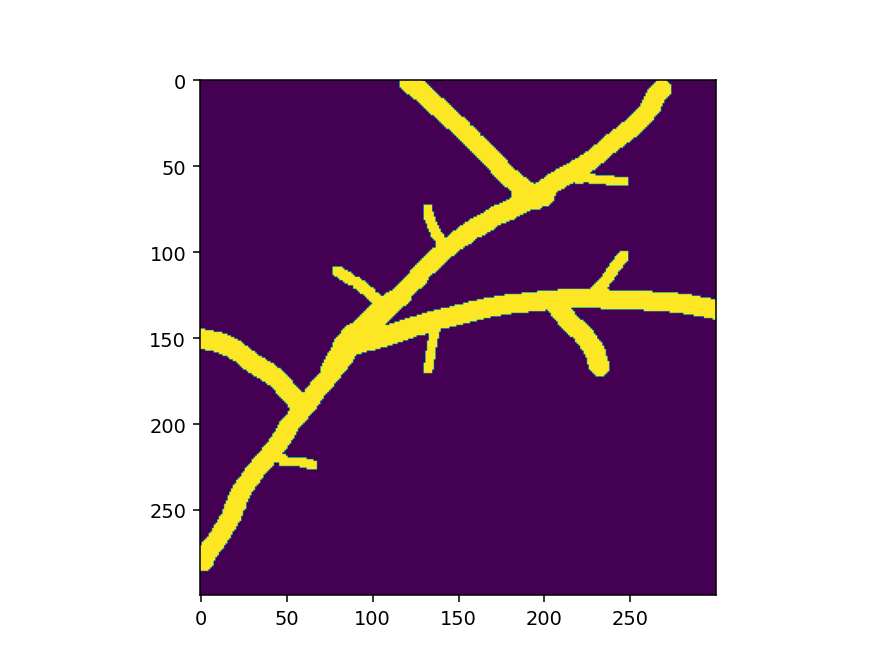

In [15]:
plt.figure()
plt.imshow(img)

In [2]:
# importando a img
img = plt.imread('Vaso_amao.png')
img = (1 - img).astype(np.uint8)
img = transform_rgb_to_gray(img)
#esqueletizacao
img_skel = np.array((skimage.morphology.skeletonize(img, method = 'lee')))

# grafo
graph_skeleton = creation.create_graph(im.Image(img_skel))
graph_skeleton = ad.simplify(graph_skeleton)
graph_skeleton = ad.adjust_graph(graph_skeleton, 0)

In [3]:
def find_terminate_node(graph):
    """
    Função para encontrar os nós terminais de um grafo
    
    Input:
    graph: [networkx multigraph] grafo para analise
    
    output:
    node_terminate: [list] nós terminais do grafo
    """
    node_terminate = []
    for node in graph:
        if graph.degree(node) == 1:
            node_terminate.append(node)
    return node_terminate

In [4]:
def find_edges(graph):
    """
    Função que retorna todas as arestas de um grafo
    
    Input:
    graph: [networkx multigraph] grafo para analise
    
    output:
    dict_edges: [dict] contem as arestas do grafo
    """
    dict_edges = {}
    for idx, edge in enumerate(graph.edges(keys = True), 1):
        dict_edges[edge] = idx
    return dict_edges

https://www.copict.ufscar.br/arquivos/edital-001-2022/roteiro-para-elaboracao-de-relatorio-parcial-de-ict.pdf

pdf do relatorio parcial

In [5]:
def find_pixel_in(dict_id_comp):
    for idx, value in enumerate(dict_id_comp.items()):
        _, node = get_edge_id_from_node(value[0], dict_edges)
        path = graph_skeleton.get_edge_data(node[0], node[1])[0]['path']
        line = value[1]['line']
        flag = False

        for i in range(len(value[1]['line'][0])):
            pixel = (line[0][i], line[1][i])
            if pixel in path:
                dict_id_comp[value[0]]['pixel_inner'] = pixel
                flag = True
                break
            else:
                pix_viz = neibor_4(pixel)
                for j in range(len(path)):
                    pixel_skel = path[j]

                    if pixel_skel in pix_viz:
                        dict_id_comp[value[0]]['pixel_inner'] = pixel_skel
                        flag = True
                        break
            if flag:
                break


        if flag is False:
            dict_id_comp[value[0]]['pixel_inner'] = None
            print(node, False)
    return

In [6]:
def neibor_4(pixel):
    list_viz = [(pixel[0], pixel[1]-1),
                        (pixel[0], pixel[1]+1),
                        (pixel[0] + 1, pixel[1]),
                        (pixel[0] - 1, pixel[1])
                        ]
    return set(list_viz)

In [7]:
def neibor_8(pixel):
    list_viz = [(pixel[0], pixel[1]-1),
                        (pixel[0], pixel[1]+1),
                        (pixel[0] + 1, pixel[1]),
                        (pixel[0] - 1, pixel[1]),
                        (pixel[0] + 1, pixel[1]-1),
                        (pixel[0] - 1, pixel[1]+1),
                        (pixel[0] - 1, pixel[1]-1),
                        (pixel[0] + 1, pixel[1]+1)
                       ]
    return set(list_viz)

In [8]:
"""# colcoar essa celula em uma função dentro do obbjeto em baixo
# calcular o avgradiusmean em outra função
dist = distance(img)
for node1, node2, key, path in graph_skeleton.edges(data = 'path', keys = True):
    radius = []
    for pixel in path:
        radius_pixel = dist[pixel]
        radius.append(radius_pixel)
    graph_skeleton[node1][node2][key]['radius'] = radius
    #graph_skeleton.edges[(node1, node2, key)]['radius'] = radius"""

"# colcoar essa celula em uma função dentro do obbjeto em baixo\n# calcular o avgradiusmean em outra função\ndist = distance(img)\nfor node1, node2, key, path in graph_skeleton.edges(data = 'path', keys = True):\n    radius = []\n    for pixel in path:\n        radius_pixel = dist[pixel]\n        radius.append(radius_pixel)\n    graph_skeleton[node1][node2][key]['radius'] = radius\n    #graph_skeleton.edges[(node1, node2, key)]['radius'] = radius"

In [9]:
### grafo.edges
#graph_skeleton.edges(data = True)

In [10]:
class graph:
    def __init__(self, graph, seg):
        self.find_radius_graph(graph)
        # imagem segmentada
        self.seg = seg
        
        # grafo networkx
        self.graph = graph
        
        # nós terminais
        self.node_terminate = self.find_terminate_node(graph)
        
        # arestas
        self.edges = self.find_edges(graph)
        
        # Criando imagem de borda
        self.border = self.create_border_img(seg)
        
        # conjunto de pontos mais proximos de cada nó
        self.close_node, self.tip_radius = self.find_pixels_node(graph, self.border)
        
        # criando a imagem de ID's
        self.img_id, self.transf_dist_skel_border = self.create_ID_img(graph, self.border, seg)
       
        # variavel com os componentes centrais de cada nó
        self.comps = self.find_center_comps(self.close_node)
        
        # um dicionario contendo os pixeis de linha para cada ID de nó
        self.line, self_pixel_comp = self.get_component_id(graph, self.node_terminate, self.edges, self.comps)
        
        self.pixel_inner = self.find_pixel_in(self.comps, graph, self.edges, self.line)
        
        # dicionario contendo o innerlenght para cada nó do grafo
        self.innerlength = self.find_innerlenght(graph, self.comps, self.edges, self.pixel_inner)
        
        # dicionario contendo o outerlenght de cada nó
        self.outerlength = self.find_outerlenght(graph, self.comps, self.edges, self.pixel_inner)
        
        self.avg_radius_mean = self.find_avgRadiusMean(graph, self.edges, self.outerlength)
        
        self.bulge_size = self.get_bulge_size(graph, self.innerlength, self.tip_radius, self.avg_radius_mean,
                                             self.node_terminate, self.edges)
        
    def find_terminate_node(self, graph):
        """
        Função para encontrar os nós terminais de um grafo

        Input:
        graph: [networkx multigraph] grafo para analise

        output:
        node_terminate: [list] nós terminais do grafo
        """
        node_terminate = []
        for node in graph:
            if graph.degree(node) == 1:
                node_terminate.append(node)
        return node_terminate
    def find_edges(self, graph):
        """
        Função que retorna todas as arestas de um grafo

        Input:
        graph: [networkx multigraph] grafo para analise

        output:
        dict_edges: [dict] contem as arestas do grafo
        """
        dict_edges = {}
        for idx, edge in enumerate(graph.edges(keys = True), 1):
            dict_edges[edge] = idx
        return dict_edges
        
    def create_border_img(self, seg):
        '''
        Criação da imagem de bordas
        input:
        seg: [img] imagem de segmentação
        
        Output:
        border: [img] imagem contendo as bordas da imagem de segmentação
        '''
        border = seg-ndi.binary_erosion(seg)
        return border
        
    def find_pixels_node(self, graph, img_borda, k = 20):
        '''
        Função para encontrar os K pixeis de borda mais proximos
        de cada ponto central dos nós do grafo
        Input:
        graph: [multigraph networkx] grafo do esqueleto
        img_borda: [img] imagem contendo os pixeis de borda da segmentação
        k: [int] quantidade de vizinhos mais próximos de cada nó
        
        Output:
        close_node: [dict] dicionario contendo o ID das bifurcações como chave e 
        os pixeis mais próximos de cada nó
        '''
        pontos_bif = []
        pontos_borda = []
        # encontrando todos os pontos do centro de cada nó
        for ponto in graph.nodes:
            pontos_bif.append(graph.nodes(data = True)[ponto]['center'])
        # armazenando em um vetor
        pontos_bif = np.array(pontos_bif)
        border_ = np.nonzero(img_borda)
        for i in range(len(border_[0])):
            pontos_borda.append([border_[0][i], border_[1][i]])
        pontos_borda = np.array(pontos_borda)
        
        m_dist = cdist(pontos_bif, pontos_borda)
        ind = np.argsort(m_dist, axis = 1)
        close_node = {}
        tip_radius = {}
        for idx_bif in range(len(pontos_bif)):
            radius = {}
            radius['pixel'] = pontos_borda[ind[idx_bif, 0], :]
            tip_radius[idx_bif] = radius 
            close_node[idx_bif] = pontos_borda[ind[idx_bif, :k], :]
        for idx in tip_radius:
            dict_line = {}
            dict_line = tip_radius[idx]
            row_r, col_r = tip_radius[idx]['pixel']
            row_b, col_b = pontos_bif[idx]
            line = skimage.draw.line(row_r, col_r, row_b, col_b)
            dict_line['line'] = line
            tip = 0
            for pos in range(len(line[0]) - 1):
                viz_4 = neibor_4((line[0][pos], line[1][pos]))
                viz_8 = neibor_8((line[0][pos], line[1][pos]))
                if (line[0][pos+1], line[1][pos + 1]) in viz_4:
                    tip += 1
                elif (line[0][pos+1], line[1][pos+1]) in viz_8:
                    tip += np.sqrt(2)
            dict_line['radius'] = tip
            tip_radius[idx] = dict_line
        
        return close_node, tip_radius    
        
        
    def create_ID_img(self, graph, border, seg):
        """
        Função para criar a imagem de ID's de cada aresta de um grafo
        Input:
        graph: [networkx multigraph] grafo contendo o esqueleto
        border: [img] imagem de pixeis de borda da imagem de segmentação
        seg: [img] imagem de segmentação
        """
        img_graph = util.graph_to_img(graph, img_shape = seg.shape, node_color = (0,0,0),
                                      node_pixels_color = (0, 0, 0), edge_color = (255, 255, 255)
                                     )
        img_graph = transform_nonbinary(img_graph)
        img_distance, indices = distance(1-img_graph, return_indices = True)
        distance_transform_skel_border = {}
        distance_transform_skel_border['img'] = img_distance
        distance_transform_skel_border['index'] = indices
        
        img_id_func = np.zeros(seg.shape, dtype = np.uint8)
        
        row, col = np.nonzero(seg)
        
        for i in range(len(row)):
            pixel_skel = (indices[0, row[i], col[i]], indices[1, row[i], col[i]])

            for idx, edge in enumerate(graph.edges, 1):
                row_col = graph.get_edge_data(edge[0], edge[1])[0]['path']
                if pixel_skel in row_col:
                    img_id_func[row[i], col[i]] = idx
                            
        img_id = np.zeros(img.shape, dtype = np.uint8)
        row, col = np.nonzero(seg)
        img_id[row, col] = img_id_func[row, col]
        plt.figure()
        plt.imshow(img_id)
        return img_id, distance_transform_skel_border
    
    
    
    def find_center_comps(self, close_node):
        '''
        Função para separar os componentes conexos dos vizinhos mais próximos de cada nó do grafo
        Input:
        close_node: [dict] dicionario contendo os pixeis mais proximos de cada nó
        
        Output:
        dict_comps: [dict] dicionario contendo os 3 componentes conexos mais próximos de cada nó
        '''
        dict_comps = {}
        for key in range(len(close_node)):
            pixels = close_node[key]
            pixels_set = set(tuple(i) for i in zip(pixels[:,0], pixels[:,1]))
            comps = []
            for i in range(3):
                comp_set = []
                if len(pixels_set) == 0:
                    continue
                for pixel in pixels_set:
                    list_viz = neibor_8(pixel)
                    # numeros de vizinhos
                    num_nei = 0
                    for pix_viz in list_viz:
                        if pix_viz in pixels_set:
                            num_nei += 1
                    if num_nei == 1:
                        break
                pixels_set.remove(pixel)
                comp_set.append(pixel)
                pix_to_visit = [pixel] 

                while len(pix_to_visit) > 0:
                    pixel = pix_to_visit.pop(0)
                    list_viz = neibor_8(pixel)

                    for pix_viz in list_viz:
                        if pix_viz in pixels_set:
                            pixels_set.remove(pix_viz)
                            comp_set.append(pix_viz)
                            pix_to_visit.append(pix_viz)
                comps.append(list(comp_set))
            if len(pixels_set) > 0:
                print(pixels_set)
                print('ID:', key, 'não fechou tudo')
            dict_comps[key] = comps
        return dict_comps
            
    def get_edge_id_from_node(self, graph, node_id, dict_edges):
        """
        Função para encontrar a aresta de um determinado nó
        input:
        graph: [networkx multigraph] grafo contendo o esqueleto
        node_id: [int] ID do nó a ser analisado
            OBS: assume-se que tenha grau 1
        dict_edges: [dict] dicionario contendo as arestas
        
        output:
        dict_edges[edges]: [int] numero de ID da aresta
        edges: [tuple] tupla contendo a aresta
        """
        edges = list(graph.edges(node_id, keys = True))[0]
        if edges in dict_edges:
            return dict_edges[edges], edges
        edges = (edges[1], edges[0], edges[-1])
        return dict_edges[edges], edges
    
    def get_component_id(self, graph, node_terminate, dict_edges, dict_comps):
        """
        Função para encontrar o ponto central de cada um dos componentes conexos de cada nó terminal

        Inputs:
        node_terminate: [list] lista contendo os nós terminais
        dict_edges: [dict] dicionario contendo as arestas de um determinado grafo
        dict_comps: [dict] dicionario contendo os componentes de cada aresta

        Output:
        dict_id_comp: [dict] dicionario contendo dois pontos para cada uma das arestas
        """
        img_id = self.img_id

        line = {}
        pixel_comp = {}
        for node in node_terminate:
            edge_id, _ = self.get_edge_id_from_node(graph, node, dict_edges)
            bif_id = list(graph.neighbors(node))[0]
            comp_in =[]
            for comp in dict_comps[bif_id]:
                if img_id[comp[0]] == edge_id or img_id[comp[-1]] == edge_id:
                    comp_in.append(comp[len(comp)//2])
            linha = skimage.draw.line(comp_in[0][0], comp_in[0][1], comp_in[1][0], comp_in[1][1])
            # dicionario que conterá a linha e os pontos
            line[node] = linha
            pixel_comp[edge_id] = comp_in
        return line, pixel_comp
    
    
    def find_pixel_in(self, dict_id_comp, graph, edges, dict_line):
        """
        Função para encontrar o pixel de divisão do ramo central para o ramo terminal
        Input:
        dict_id_comp: [dict] dicionario contendo os componentes conexos mais proximos de cada nó
        graph: [networkx multigraph] grafo contendo o esqueleto
        edges: [dict] dicionario contendo as arestas do grafo
        dict_line: [dict] dicionario contendo os pixeis de linha de transição do ramo central para o terminal
        
        Output:
        pixel_in: [dict] dicionario contendo o pixel inner de cada nó terminal
        """
        pixel_in = {}
        for idx, value in enumerate(dict_id_comp.items()):
            if idx not in dict_line.keys():
                continue
            _, node = self.get_edge_id_from_node(graph, value[0], edges)
            path = graph.get_edge_data(node[0], node[1])[0]['path']
            line = dict_line[idx]
            flag = False

            for i in range(len(line[0])):
                pixel = (line[0][i], line[1][i])
                if pixel in path:
                    pixel_in[idx] = pixel
                    flag = True
                    break
                else:
                    pix_viz = neibor_4(pixel)
                    for j in range(len(path)):
                        pixel_skel = path[j]

                        if pixel_skel in pix_viz:
                            pixel_in[idx] = pixel_skel
                            flag = True
                            break
                if flag:
                    break


            if flag is False:
                pixel_in[idx] = None
                print(node, False)
        return pixel_in
    
    
    def find_innerlenght(self, graph, dict_id_comps, dict_edges,pixel_in):
        '''
        This function find the graph innerlenght for each node

        Input:
        graph: [networkx multigraph] graph contain skeleton
        dict_id_comps: [dict] dictiomary contain terminate nodes, pixels for trace a line, 
            and pixel_inner (pixel to intersection of skeleton and line)
        dict_edges: [dict] dictionary contain all edges to graph

        Output:

        '''
        inner_length = {}

        for _, value in enumerate(dict_id_comps.items()):
            if value[0] not in pixel_in.keys():
                continue
            id_edge, edge = self.get_edge_id_from_node(graph, value[0], dict_edges)
            
            pixeis = graph.get_edge_data(edge[0], edge[1])[0]['path']
            point_in = pixel_in[value[0]]
            if point_in is None:
                inner_length[value[0]] = None
                continue
            inner = 0
            for idx in range(len(pixeis)):
                row, col = pixeis[idx]
                if (row, col - 1) == pixeis[idx - 1] or (row-1, col) == pixeis[idx - 1] or (row, col + 1) == pixeis[idx - 1] or (row + 1, col) == pixeis[idx - 1]:
                    inner += 1
                elif (row-1, col - 1) == pixeis[idx - 1] or (row+1, col - 1) == pixeis[idx - 1] or (row-1, col + 1) == pixeis[idx - 1] or (row + 1, col + 1) == pixeis[idx - 1]:
                    inner += np.sqrt(2)
                if pixeis[idx] == point_in:
                    break
            inner_length[value[0]] = inner
        return inner_length
    
    def find_outerlenght(self, graph, dict_id_comps, dict_edges,pixel_in):
        '''
        This function find the graph outerlenght for each node

        Input:
        graph: [networkx multigraph] graph contain skeleton
        dict_id_comps: [dict] dictiomary contain terminate nodes, pixels for trace a line, 
            and pixel_inner (pixel to intersection of skeleton and line)
        dict_edges: [dict] dictionary contain all edges to graph

        Output:

        '''
        outer_length = {}

        for _, value in enumerate(pixel_in.items()):           
            edge = self.get_edge_id_from_node(graph, value[0], dict_edges)[1]
            pixeis = graph.get_edge_data(edge[0], edge[1])[0]['path']
            point_in = pixel_in[value[0]]
            if point_in is None:
                outer_length[value[0]] = None
                continue
            outer = 0
            for idx in range(len(pixeis)):
                if pixeis[idx] == point_in:
                    index = idx
                    break
            pixel = []
            dict_px = {}
            for idx in range(index + 1, len(pixeis)):
                row, col = pixeis[idx]
                pixel.append((row, col))
                if (row, col - 1) == pixeis[idx - 1] or (row-1, col) == pixeis[idx - 1] or (row, col + 1) == pixeis[idx - 1] or (row + 1, col) == pixeis[idx - 1]:
                    outer += 1
                elif (row-1, col - 1) == pixeis[idx - 1] or (row+1, col - 1) == pixeis[idx - 1] or (row-1, col + 1) == pixeis[idx - 1] or (row + 1, col + 1) == pixeis[idx - 1]:
                    outer += np.sqrt(2)
            dict_px['pixel'] = pixel
            dict_px['value'] = outer
            outer_length[value[0]] = dict_px
        return outer_length
            
    def find_radius_graph(self, graph):
        dist = distance(img)
        for node1, node2, key, path in graph_skeleton.edges(data = 'path', keys = True):
            radius = []
            for pixel in path:
                radius_pixel = dist[pixel]
                radius.append(radius_pixel)
            graph_skeleton[node1][node2][key]['radius'] = radius
        return
            
    def find_avgRadiusMean(self, graph, edges, px_outer):
        avgradiusmeans = {}
        for node in px_outer:
            avg_radius = 0
            #print(outer)
            pixels = px_outer[node]['pixel']
            id_edge, edge = self.get_edge_id_from_node(graph, node, edges)
            data = graph.get_edge_data(edge[0], edge[1])[0]
            path = data['path']
            radius = data['radius']
            for pos in range(len(path)):
                if path[pos] not in pixels:
                    continue
                avg_radius += radius[pos]
            avgradiusmeans[id_edge] = avg_radius / len(pixels)
        return avgradiusmeans
    
    def get_bulge_size(self, graph, inner, tip_radius, avg_radius, node_terminal, edges):
        bulge = {}
        for node in node_terminal:
            id_edge, edge = self.get_edge_id_from_node(graph, node, edges)
            length = graph.get_edge_data(edge[0], edge[1])[0]['length']
            innerlength = inner[node]
            tip = tip_radius[node]['radius']
            radius_mean = avg_radius[id_edge]
            bulge[id_edge] = (length - innerlength + tip)/radius_mean
            #print('ID', id_edge, 'innerlength', innerlength, 'length', length, 'tip radius', tip, 'avg radius', radius_mean)
        return bulge

{5: 16.342707963801413, 3: 12.41663892376127, 2: 8.061060078010426, 7: 7.741713812377092, 10: 7.018712216325039, 14: 8.67391172596515, 9: 11.445695420786759, 18: 11.813024817920464, 11: 7.817322194551432, 16: 8.060118686165628, 20: 7.57296157871994, 21: 13.577388732779973}
{(0, 1, 0): 1, (0, 12, 0): 2, (0, 11, 0): 3, (1, 2, 0): 4, (1, 10, 0): 5, (2, 5, 0): 6, (2, 13, 0): 7, (3, 4, 0): 8, (3, 16, 0): 9, (3, 14, 0): 10, (4, 18, 0): 11, (4, 6, 0): 12, (5, 7, 0): 13, (5, 15, 0): 14, (6, 7, 0): 15, (6, 19, 0): 16, (7, 8, 0): 17, (8, 17, 0): 18, (8, 9, 0): 19, (9, 20, 0): 20, (9, 21, 0): 21}


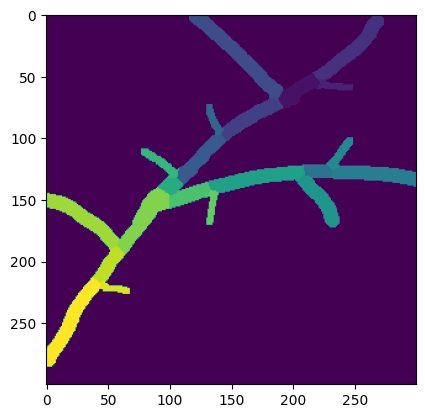

In [11]:
###%%prun
grafo = graph(graph_skeleton, img)
#print(grafo.outerlength)
print(grafo.bulge_size)
print(grafo.edges)

<IPython.core.display.Javascript object>


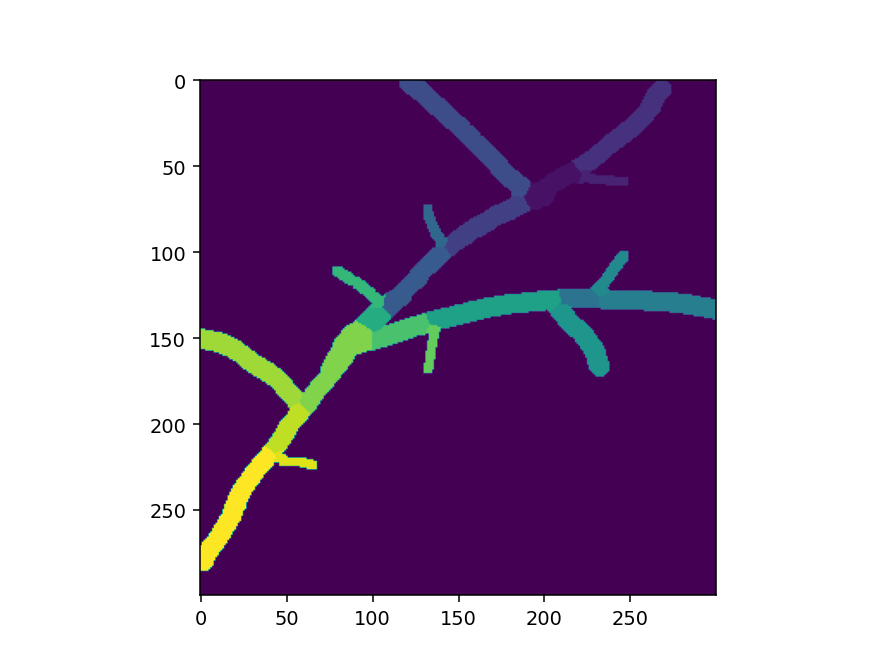

In [12]:
%matplotlib notebook

plt.figure()
plt.imshow(grafo.img_id)

# Proxima semana

Fazer duas imagens novas na mao, uma com o mesmo comprimento variando o raio e outra variando o comprimento e deixando o raio fixo

Fazer uma verificação para ver se o bulgesize nao esta dividindo com none, caso o avg radius mean nao chegue a linha do vaso

Fazer um plote em consideracao do raio e o length

resgatar o codigo de gerar imagens ruidosas para fazer uma nova geração de ruidos



(300, 300)


<IPython.core.display.Javascript object>


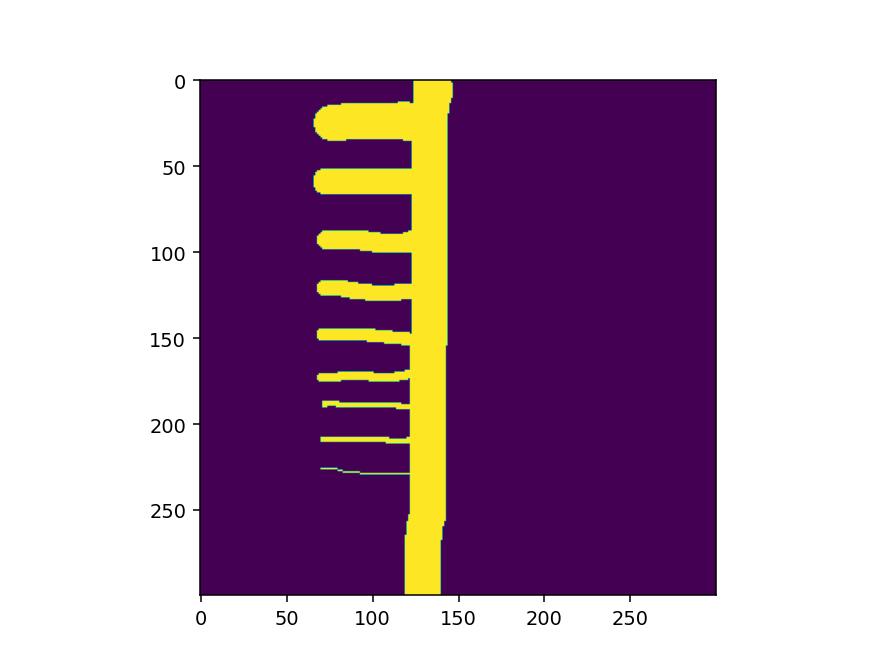

In [13]:
img_raio = plt.imread('varia_raio.png')
img_raio = transform_rgb_to_gray(img_raio)
img_raio = img_raio.astype(np.uint8)
print(img_raio.shape)


#esqueletizacao
img_raio_skel = np.array((skimage.morphology.skeletonize(img_raio, method = 'lee')))

# grafo
graph_skeleton = creation.create_graph(im.Image(img_raio_skel))
graph_skeleton = ad.simplify(graph_skeleton)
graph_skeleton = ad.adjust_graph(graph_skeleton, 0)

plt.figure()
plt.imshow(img_raio)

<IPython.core.display.Javascript object>


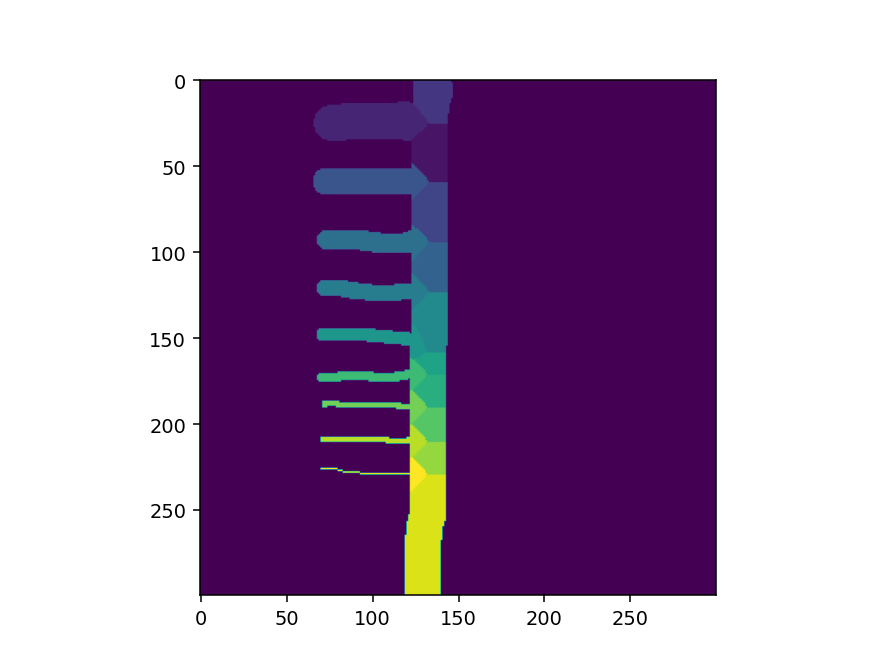

{(34, 85)}
ID: 10 não fechou tudo
{(53, 69), (63, 67), (65, 69), (55, 67)}
ID: 11 não fechou tudo


IndexError: list index out of range

In [14]:
graph_radius = graph(graph_skeleton, img_raio)

In [ ]:
debug

In [ ]:
%matplotlib notebook
plt.figure()
plt.imshow(img_raio + img_raio_skel)

In [ ]:
grafo.close_node